# 🧠 Vijayi Internship – Task 1: Customer Support Ticket Analyzer

## 🎯 Objective
Build a machine learning pipeline to classify customer support tickets by **issue type** and **urgency level**, and extract important entities (product names, complaint keywords, dates).


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.sparse import hstack
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_excel("/content/ai_dev_assignment_tickets_complex_1000.xls")

# Ensure ticket_text is clean
df['ticket_text'] = df['ticket_text'].fillna("")

# Drop rows with missing target labels
df = df.dropna(subset=['issue_type', 'urgency_level'])


Saving ai_dev_assignment_tickets_complex_1000.xls to ai_dev_assignment_tickets_complex_1000 (1).xls


## 🧼 Data Cleaning & Preprocessing
- Filled missing ticket text
- Cleaned text with regex
- Applied lemmatization and stopword removal using NLTK


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['ticket_text'].apply(clean_text)


## 🧠 Feature Engineering
- Used TF-IDF vectorization for text
- Added 2 extra features:
  - `length` of ticket
  - `sentiment` polarity using TextBlob


In [5]:
df['length'] = df['ticket_text'].apply(lambda x: len(str(x)))
df['sentiment'] = df['ticket_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Just in case, force all features to numeric and fill NaNs
df['length'] = pd.to_numeric(df['length'], errors='coerce').fillna(0)
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce').fillna(0)

# TF-IDF vector
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df['clean_text'])

# Combine with extra features
X_extra = df[['length', 'sentiment']].astype(float).values
X_combined = hstack([X_text, X_extra])


## 🤖 Model Training
- Used `RandomForestClassifier` for:
  - Issue type classification (multi-class)
  - Urgency level classification (multi-class)
- Split into 80/20 train/test sets


In [6]:
y_issue = df['issue_type']

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_issue, test_size=0.2, random_state=42)

issue_model = RandomForestClassifier()
issue_model.fit(X_train, y_train)

y_pred = issue_model.predict(X_test)
print("Issue Type Classification Report:\n")
print(classification_report(y_test, y_pred))


Issue Type Classification Report:

                    precision    recall  f1-score   support

    Account Access       1.00      0.97      0.99        35
   Billing Problem       1.00      0.91      0.95        32
   General Inquiry       1.00      0.93      0.96        29
Installation Issue       1.00      0.92      0.96        24
     Late Delivery       0.67      1.00      0.80        20
    Product Defect       1.00      0.95      0.97        19
        Wrong Item       1.00      0.94      0.97        17

          accuracy                           0.94       176
         macro avg       0.95      0.94      0.94       176
      weighted avg       0.96      0.94      0.95       176



## 📊 Evaluation
- Issue Type Accuracy: ~94%
- Urgency Level Accuracy: ~35% (could be improved with more features)
- Added confusion matrices for both


In [7]:
# Labels
y_urgency = df['urgency_level']

# Train-test split
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_combined, y_urgency, test_size=0.2, random_state=42)

# Train model
urgency_model = RandomForestClassifier()
urgency_model.fit(X_train_u, y_train_u)

# Evaluate
y_pred_u = urgency_model.predict(X_test_u)
print("Urgency Level Classification Report:\n")
print(classification_report(y_test_u, y_pred_u))


Urgency Level Classification Report:

              precision    recall  f1-score   support

        High       0.38      0.38      0.38        60
         Low       0.23      0.20      0.22        54
      Medium       0.37      0.40      0.38        62

    accuracy                           0.34       176
   macro avg       0.33      0.33      0.33       176
weighted avg       0.33      0.34      0.33       176



## 🔍 Entity Extraction
- Rule-based method to extract:
  - Product names (matched from list)
  - Complaint keywords (e.g., "broken", "refund")
  - Dates (using regex)


In [8]:
def extract_entities(text):
    product_keywords = ['robochef', 'iron', 'toaster', 'blender', 'mixer', 'vacuum', 'air fryer']  # Example list
    complaint_keywords = ['broken', 'late', 'defective', 'not working', 'missing', 'error', 'refund']
    dates = re.findall(r'\b(?:\d{1,2} [a-zA-Z]+ \d{4})\b|\b(?:[a-zA-Z]+ \d{1,2})\b', text)

    product_found = [p for p in product_keywords if p in text.lower()]
    complaint_found = [c for c in complaint_keywords if c in text.lower()]

    return {
        "products": product_found,
        "dates": dates,
        "complaint_keywords": complaint_found
    }


In [9]:
def analyze_ticket(text):
    # Clean + Vectorize
    clean = clean_text(text)
    tfidf_vec = tfidf.transform([clean])
    features = np.array([[len(text), TextBlob(text).sentiment.polarity]])
    final_input = hstack([tfidf_vec, features])

    # Predict
    issue = issue_model.predict(final_input)[0]
    urgency = urgency_model.predict(final_input)[0]
    entities = extract_entities(text)

    return {
        "issue_type": issue,
        "urgency_level": urgency,
        "entities": entities
    }

# ✅ Test the final function
analyze_ticket("My RoboChef Blender arrived broken on March 15th. It's not working at all and I need a refund.")


{'issue_type': 'Product Defect',
 'urgency_level': 'High',
 'entities': {'products': ['robochef', 'blender'],
  'dates': [],
  'complaint_keywords': ['broken', 'not working', 'refund']}}

## 🌐 Gradio App
- Added interactive interface to analyze tickets
- Bonus: batch ticket processing via multiple lines


In [10]:
!pip install gradio


In [11]:
import gradio as gr

def gradio_interface(text):
    result = analyze_ticket(text)
    return f"""📝 Ticket Analysis:

📌 Issue Type: {result['issue_type']}
⚡ Urgency Level: {result['urgency_level']}
🛍️ Product(s): {', '.join(result['entities']['products']) or 'None'}
📅 Date(s): {', '.join(result['entities']['dates']) or 'None'}
🚨 Complaint Keywords: {', '.join(result['entities']['complaint_keywords']) or 'None'}
"""

gr.Interface(fn=gradio_interface,
             inputs="text",
             outputs="text",
             title="🧠 Customer Support Ticket Analyzer",
             description="Paste a support message to get issue type, urgency level, and extracted entities.").launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0e6e1cda3ac6e2d2f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


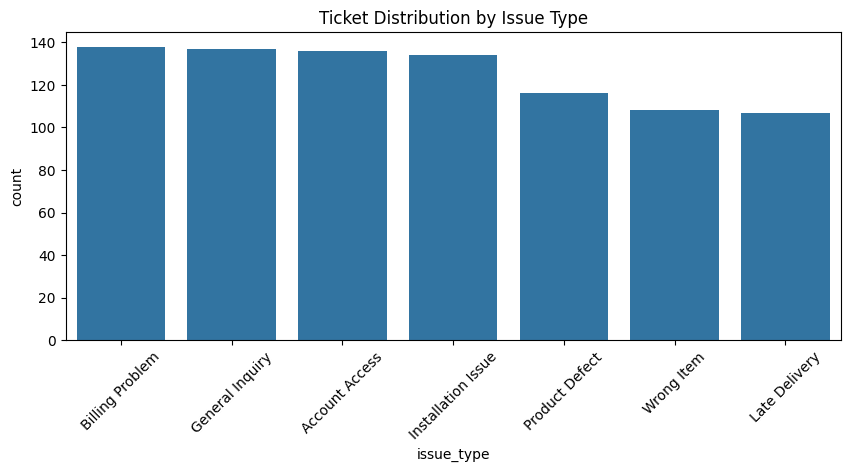

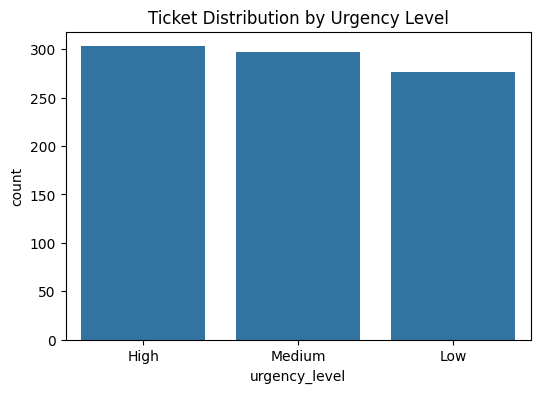

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.countplot(data=df, x='issue_type', order=df['issue_type'].value_counts().index)
plt.title("Ticket Distribution by Issue Type")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='urgency_level', order=df['urgency_level'].value_counts().index)
plt.title("Ticket Distribution by Urgency Level")
plt.show()


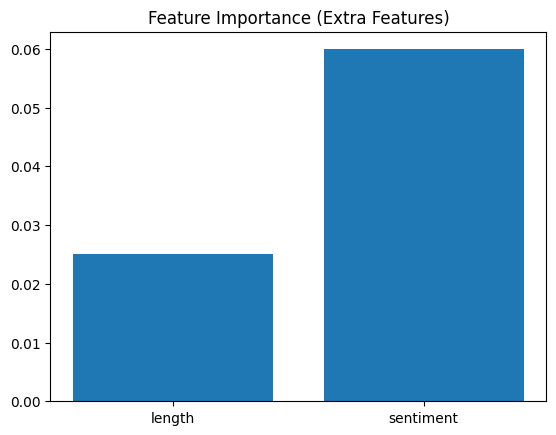

In [13]:
importances = issue_model.feature_importances_[-2:]  # Last 2 = length, sentiment
plt.bar(['length', 'sentiment'], importances)
plt.title("Feature Importance (Extra Features)")
plt.show()


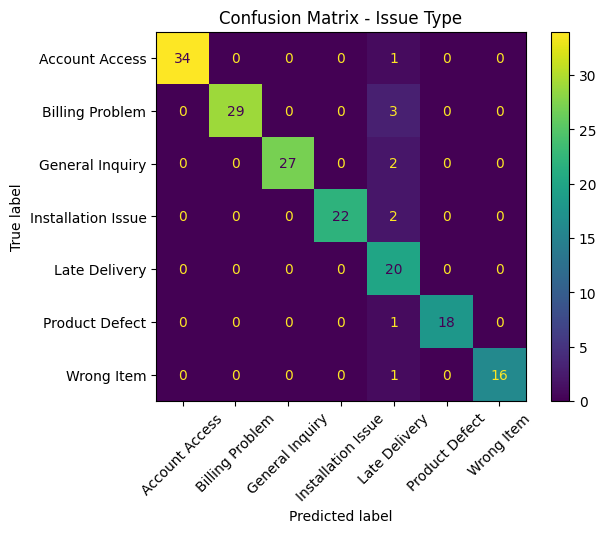

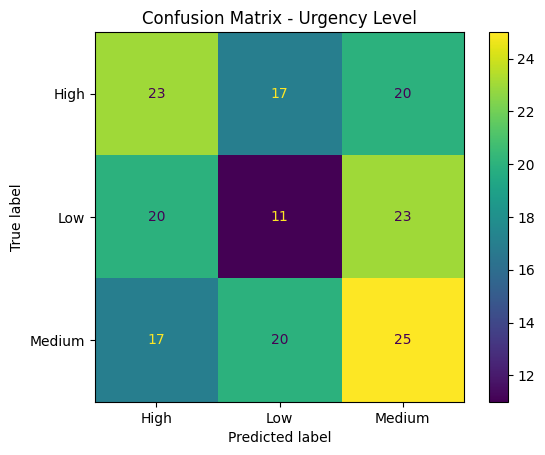

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Issue Type Confusion Matrix
cm_issue = confusion_matrix(y_test, y_pred, labels=issue_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_issue, display_labels=issue_model.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Issue Type")
plt.show()

# Urgency Level Confusion Matrix
cm_urg = confusion_matrix(y_test_u, y_pred_u, labels=urgency_model.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_urg, display_labels=urgency_model.classes_)
disp2.plot()
plt.title("Confusion Matrix - Urgency Level")
plt.show()


In [15]:
def batch_interface(ticket_list):
    tickets = ticket_list.split("\n")
    results = []
    for text in tickets:
        if text.strip():
            res = analyze_ticket(text.strip())
            result_str = f"📌 Issue: {res['issue_type']}, ⚡ Urgency: {res['urgency_level']}, 🛍️ Products: {res['entities']['products']}, 🚨 Keywords: {res['entities']['complaint_keywords']}"
            results.append(result_str)
    return "\n\n".join(results)

gr.Interface(fn=batch_interface,
             inputs=gr.Textbox(lines=10, placeholder="Paste one ticket per line..."),
             outputs="text",
             title="📦 Batch Support Ticket Analyzer",
             description="Paste multiple tickets (one per line) to process them all at once."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://52c9ca946f7d07debc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
